In [2]:
import cv2
import numpy as np
import os 
from PIL import Image
from facenet_pytorch import MTCNN
import torch
from torchvision import transforms

e:\anaconda3\envs\pytorch2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
mtcnn = MTCNN(image_size=224, margin=20, keep_all=True)
to_pil = transforms.ToPILImage()

### Checking Face Recognition

In [38]:
video_file = r"E:\new_dfdc_dataset\dfdc_train_part_00\real\aayrffkzxn.mp4"

cap = cv2.VideoCapture(video_file)

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
total_frames

300

In [18]:
vid_path = r"E:\new_dfdc_dataset\dfdc_train_part_00\fake\bdnoxibdvz.mp4"

cap = cv2.VideoCapture(vid_path)
curr = 5
count = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    if count == curr:
        cv2.imwrite(r"E:\zz__face_cropped_dataset\train\real\afbgivckik.mp4\fake_check.jpg", frame)
        photu = frame
    count += 1

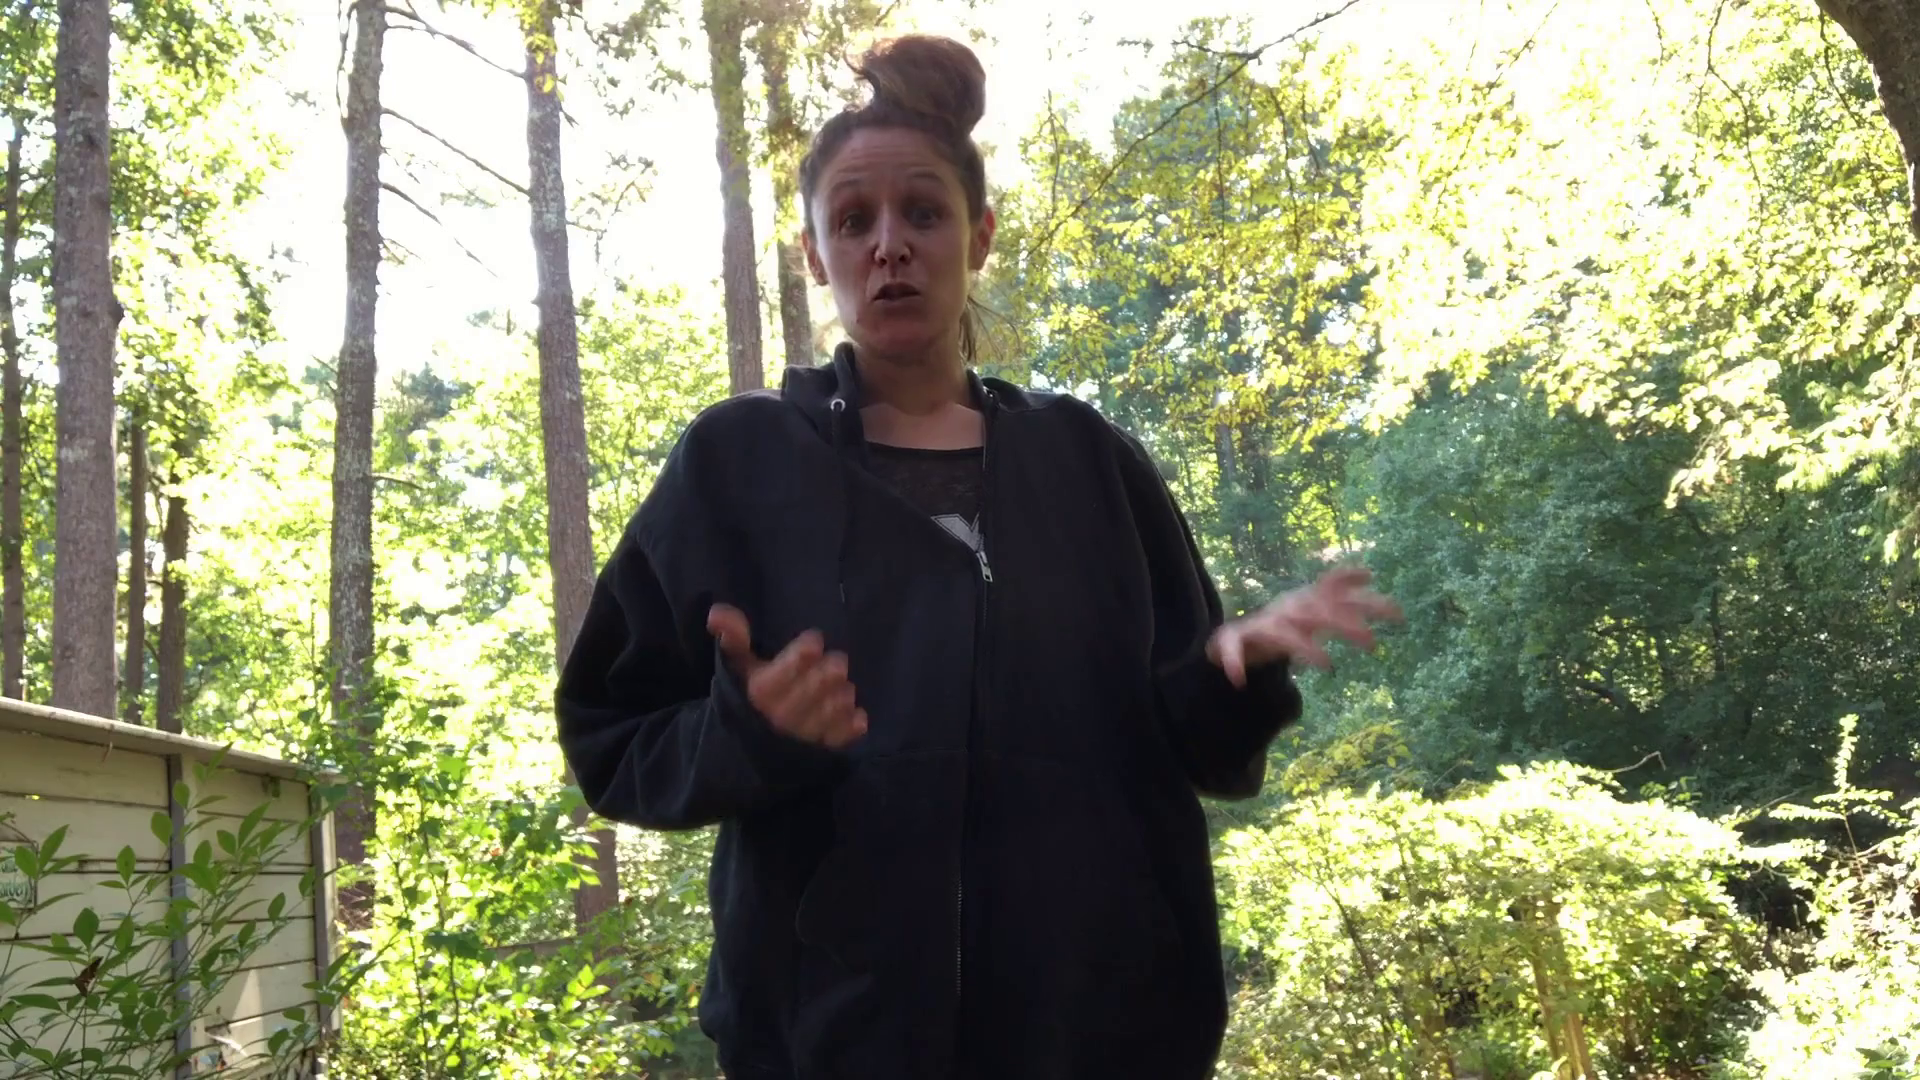

In [19]:
pil_img = to_pil(cv2.cvtColor(photu, cv2.COLOR_BGR2RGB))
pil_img

In [20]:
boxes, probs = mtcnn.detect(pil_img)
areas = [(box[2] - box[0]) * (box[3] - box[1]) for box in boxes]
largest_idx = np.argmax(areas)

In [22]:
probs

array([0.9999855756759644, 0.9356586933135986], dtype=object)

In [21]:
faces = mtcnn(pil_img)
faces.shape[0]

2

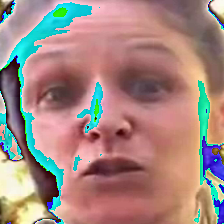

In [26]:
to_pil(faces[0])

In [64]:
faces[largest_idx]

tensor([[[ 0.0977,  0.1445,  0.1914,  ...,  0.9805,  0.9805,  0.9961],
         [ 0.1445,  0.1367,  0.1680,  ...,  0.9883,  0.9961,  0.9961],
         [ 0.1445,  0.1445,  0.1758,  ...,  0.9961,  0.9961,  0.9961],
         ...,
         [ 0.1758,  0.1680,  0.1836,  ..., -0.1602, -0.2148, -0.2305],
         [ 0.1367,  0.1523,  0.1680,  ..., -0.1914, -0.2461, -0.2695],
         [ 0.1680,  0.1602,  0.1680,  ..., -0.2539, -0.3008, -0.3164]],

        [[ 0.0430,  0.0977,  0.1445,  ...,  0.9180,  0.9102,  0.9258],
         [ 0.0977,  0.0898,  0.1133,  ...,  0.9258,  0.9414,  0.9492],
         [ 0.0977,  0.0898,  0.1211,  ...,  0.9414,  0.9492,  0.9492],
         ...,
         [ 0.1055,  0.1055,  0.1211,  ..., -0.3008, -0.3477, -0.3633],
         [ 0.0742,  0.0898,  0.1055,  ..., -0.3320, -0.3789, -0.4023],
         [ 0.1211,  0.1055,  0.1055,  ..., -0.3945, -0.4414, -0.4492]],

        [[-0.1680, -0.1055, -0.0508,  ...,  0.8555,  0.8555,  0.8789],
         [-0.1602, -0.1602, -0.1211,  ...,  0

In [77]:
len(faces)

1

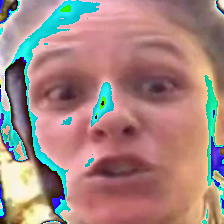

In [ ]:
img = to_pil(faces[largest_idx])  # Selecting the face with the largest box or face area in image
img

In [12]:
arr1 = np.array([1, 3, 4, 3])
arr2 = np.array([3, 1, 2, 1])

common_elements_numpy = np.intersect1d(arr1, arr2)
common_elements_numpy

array([1, 3])

## Face Extraction Start ->

In [62]:
def select_probable_face(pil_img):
    boxes, probs = mtcnn.detect(pil_img)
    # areas = [(box[2] - box[0]) * (box[3] - box[1]) for box in boxes]
    most_probable = np.argmax(probs)
    return most_probable

In [70]:
def select_top_20(all_faces):
    # print(all_faces[0].shape)
    probabilities = []
    indexes = []
    for idx, i in enumerate(all_faces):
        face_img = to_pil(i)
        boxes, probs = mtcnn.detect(face_img)
        if probs is not None and probs[0] is not None:
            probabilities.append((probs[0], idx))

    # print(probabilities)
    top_probs = sorted(probabilities,key=lambda x: x[0], reverse=True)[:20]
    # print(top_probs)
    
    top_faces = [all_faces[i] for (_, i) in top_probs]

    return top_faces


In [68]:
def extract_faces(frames, frame_names, video, to_delete_dir):
    all_faces = []
    valid = True

    for idx, frame in enumerate(frames):
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(frame_rgb)

        faces = mtcnn(pil_image)

        if faces is None:
            valid = False
            break
        if len(faces) != 1 or faces.shape[0] != 1:
            probable_face = select_probable_face(pil_image)
            all_faces.append(faces[probable_face])
        else:
            all_faces.append(faces[0])
    # print("Total faces before selecting tops: ", len(all_faces))
    all_faces = select_top_20(all_faces)

    if valid and len(all_faces) == 20:
        for i, face_tensor in enumerate(all_faces):
            face_img = transforms.ToPILImage()(face_tensor)
            face_img.save(frame_names[i])
            # cv2.imwrite(frame_names[i], face_img)
            # print("Image Number: ", count)
            
        print("Done: ")
    else:
        print(f"Invalid Video: {video}")
        # print(len(all_faces))
        os.rmdir(to_delete_dir)

In [65]:
def extract_frames_and_save(video_file, output_folder, num_frames=35):
    os.makedirs(output_folder, exist_ok=True)
    cap = cv2.VideoCapture(video_file)

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # print(total_frames)

    if total_frames < num_frames:
        print(f"Too short video: {video_file}")
        cap.release()
        return

    frame_indices = np.linspace(2, total_frames, num_frames, dtype=int)
    # print(frame_indices)

    current_frame = 2
    frame_id = 0
    all_frames = []
    all_frame_names = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # print(current_frame)
        if current_frame in frame_indices:
            frame_filename = f"frame_{frame_id:03d}.jpg"
            frame_path = os.path.join(output_folder, frame_filename)

            all_frames.append(frame)
            all_frame_names.append(frame_path)
            # cv2.imwrite(frame_path, frame)
            frame_id += 1

        current_frame += 1

    # print(len(all_frame_names))
    # print(len(all_frames))

    extract_faces(all_frames, all_frame_names, video_file, output_folder)

    cap.release()

In [ ]:
# video = r"E:\new_dfdc_dataset\dfdc_train_part_00\real\apedduehoy.mp4"
# output_path = os.path.join(r"E:\zz__face_cropped_dataset\train\real\face_test", os.path.basename(video))
# extract_frames_and_save(video, output_path)

Total faces before selecting tops:  35
[(None, 0), (None, 1), (None, 2), (None, 3), (0.9912742972373962, 4), (0.9940735697746277, 5), (0.997026264667511, 6), (0.9819353818893433, 7), (0.9943166375160217, 8), (0.9609131813049316, 9), (None, 10), (None, 11), (None, 12), (None, 13), (None, 14), (None, 15), (None, 16), (None, 17), (None, 18), (None, 19), (None, 20), (None, 21), (None, 22), (None, 23), (None, 24), (None, 25), (None, 26), (None, 27), (None, 28), (None, 29), (None, 30), (0.9749776124954224, 31), (None, 32), (0.9220511317253113, 33), (None, 34)]


TypeError: '<' not supported between instances of 'float' and 'NoneType'

In [71]:
videos_folder = r"E:\new_dfdc_dataset\dfdc_train_part_00\real"
for video in os.listdir(videos_folder):
    video_file = os.path.join(videos_folder, video)
    output_path = os.path.join(r"F:\real\preprocessed_face_test", os.path.basename(video))
    extract_frames_and_save(video_file, output_path)

Done: 
Invalid Video: E:\new_dfdc_dataset\dfdc_train_part_00\real\apedduehoy.mp4
Done: 
Invalid Video: E:\new_dfdc_dataset\dfdc_train_part_00\real\chqqxfuuzi.mp4
Done: 
Invalid Video: E:\new_dfdc_dataset\dfdc_train_part_00\real\dhjnjkzuhq.mp4
Invalid Video: E:\new_dfdc_dataset\dfdc_train_part_00\real\didzujjhtg.mp4
Done: 
Done: 
Done: 
Invalid Video: E:\new_dfdc_dataset\dfdc_train_part_00\real\eiwtggvtfp.mp4
Invalid Video: E:\new_dfdc_dataset\dfdc_train_part_00\real\eppyqpgewp.mp4
Done: 
Done: 
Invalid Video: E:\new_dfdc_dataset\dfdc_train_part_00\real\fdpisghkmd.mp4
Invalid Video: E:\new_dfdc_dataset\dfdc_train_part_00\real\fgobmbcami.mp4
Done: 
Invalid Video: E:\new_dfdc_dataset\dfdc_train_part_00\real\fopjiyxiqd.mp4
Invalid Video: E:\new_dfdc_dataset\dfdc_train_part_00\real\fsaronfupy.mp4
Done: 
Done: 
Invalid Video: E:\new_dfdc_dataset\dfdc_train_part_00\real\gcdtglsoqj.mp4
Invalid Video: E:\new_dfdc_dataset\dfdc_train_part_00\real\gnmmhlbzge.mp4
Done: 
Invalid Video: E:\new_dfdc_d